# feature selection

下面介紹一些常見的特徵選擇的方法，第一種就是根據 Variance 去做篩選，如果有非常相似的就可以直接刪除。





In [1]:
from sklearn.feature_selection import VarianceThreshold

X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)


array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

我們也可以基於統計的變異數分析 （ANOVA） 去選，
使用 SelectKBest 直接選出最好的，
或是用 SelectPercentile 根據百分比去挑選出前面較好的特徵。


ANOVA 是 Analysis of Variance 的簡寫，
ANOVA 是先利用 F-test 估計兩個隨機變數的相關度，再去決定要不要用這個特徵， 
所以這個方法比上面說的直接設定閾值去決定要不要用來得更為科學。

下面看使用範例


In [2]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
X, y = load_iris(return_X_y=True)

print('Shape: ', X.shape)

# 最好的幾個
X_new = SelectKBest(chi2, k=2).fit_transform(X, y)
print('Best 2: ', X_new.shape)

# 前百分比好的
X_new = SelectPercentile(chi2, percentile=30).fit_transform(X, y)
X_new.shape


Shape:  (150, 4)
Best 2:  (150, 2)


(150, 1)

上面大家有注意到 chi2 嗎? 可以使用的不只有 chi2

* 對回歸問題 : f_regression, mutual_info_regression
* 對分類問題 : chi2, f_classif, mutual_info_classif

如果你的資料是稀疏資料，可以使用 chi2, mutual_info_regression, mutual_info_classif 去處理你的資料。


下面看一下 pipeline 的使用實例


In [25]:
from sklearn.datasets import load_iris
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87)


model_pipeline = Pipeline(
    [
        ("anova", SelectPercentile(chi2)),
        ("scaler", StandardScaler()),
        ("svc", SVC(C=1, random_state=87, tol=1e-5)),
    ]
)

percentiles = (1, 10, 20, 50, 100)
kernels = ('linear', 'poly', 'rbf', 'sigmoid')

for percentile in percentiles:
    for ker in kernels:
        model_pipeline.set_params(anova__percentile=percentile, svc__kernel=ker)
        model_pipeline.fit(X_train, y_train)
        print('Percent %s, kernel %s Testing accuracy: %s' % (percentile, ker, round(model_pipeline.score(X_test, y_test),3)))



Percent 1, kernel linear Testing accuracy: 0.933
Percent 1, kernel poly Testing accuracy: 0.933
Percent 1, kernel rbf Testing accuracy: 0.933
Percent 1, kernel sigmoid Testing accuracy: 0.9
Percent 10, kernel linear Testing accuracy: 0.933
Percent 10, kernel poly Testing accuracy: 0.933
Percent 10, kernel rbf Testing accuracy: 0.933
Percent 10, kernel sigmoid Testing accuracy: 0.9
Percent 20, kernel linear Testing accuracy: 0.933
Percent 20, kernel poly Testing accuracy: 0.933
Percent 20, kernel rbf Testing accuracy: 0.933
Percent 20, kernel sigmoid Testing accuracy: 0.9
Percent 50, kernel linear Testing accuracy: 0.967
Percent 50, kernel poly Testing accuracy: 0.967
Percent 50, kernel rbf Testing accuracy: 0.967
Percent 50, kernel sigmoid Testing accuracy: 0.967
Percent 100, kernel linear Testing accuracy: 0.967
Percent 100, kernel poly Testing accuracy: 0.967
Percent 100, kernel rbf Testing accuracy: 0.967
Percent 100, kernel sigmoid Testing accuracy: 0.9


In [26]:
# 可以知道 pipeline 的可調參數
model_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'anova', 'scaler', 'svc', 'anova__percentile', 'anova__score_func', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

# recursive feature elimination （RFE）

下面介紹另一種刪除特徵數量的方法， 
假設現在有10位選手，我們要從裡面選出5位較佳的選手， 
那怎麼挑選的方法有哪些？我們可以在10位裡面先剔除最弱的剩9位， 
再從9位裡面找到最弱的將他踢掉剩8位，這個步驟循環下去直到剩5位，這就是 RFE 的做法， 
但以特徵而言，我們怎麼知道哪個特徵是最弱的 或是說最不重要的， 
可以這麼說，我們拿資料來訓練一個線性模型時，當訓練好以後，檢視前面係數越小的特徵就是越不重要的， 
這樣我們就可以簡單知道不同特徵的重要性， 
在使用 RFE 的時候，我們也可以自己去選用來估計的模型。


下面來看怎麼用



In [46]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

# 建立 25 個特徵，但只有三個信號源，的 8 分類資料
X, y = make_classification(
    n_samples=1000,
    n_features=25,
    n_informative=3,
    n_redundant=2,
    n_repeated=0,
    n_classes=8,
    n_clusters_per_class=1,
    random_state=87,
)

# 使用 RFE
# n_features_to_select : 決定要多少個 feature
# step : 每一回合要刪除多少特徵
estimator = SVC(kernel='linear', C=1)
rfe = RFE(estimator=estimator, n_features_to_select=5, step=1).fit(X, y)  # n_features_to_select=10, n_features_to_select = 0.5

print('Support: \n%s' % rfe.support_)
print('Rank: \n%s' % rfe.ranking_)
print('Optimal number of features : %d' % rfe.n_features_)


Support: 
[ True False False False False False False  True False False False  True
  True False False False False  True False False False False False False
 False]
Rank: 
[ 1  2 16 18  9 19  6  1 10  5  7  1  1 15 11  4 21  1  8 14 20  3 17 13
 12]
Optimal number of features : 5


In [47]:
# 得到他
rfe.transform(X)

array([[ 1.80678641,  2.66158504, -2.46215505, -2.99051596,  0.6068705 ],
       [ 1.83963165,  2.65680383, -1.97293455, -1.59311044, -0.56114034],
       [-1.65721385, -1.94083679,  1.58932478,  1.17679536,  0.23580989],
       ...,
       [ 1.03906737,  1.23563709, -0.70309339,  0.08779769, -0.87139582],
       [ 0.86165098,  0.36885175, -0.21534377,  0.71178042, -0.55712631],
       [ 1.42597326,  0.4125871 , -0.63387651,  0.29214804,  0.04660556]])

RFE 也可以搭配 cross-validation，下面是使用範例

Support: 
[False  True False False False False False  True False False False False
 False False False False False False  True False False False False False
 False]
Rank: 
[ 5  1 12 19 15  6 17  1  2 21 23 11 16 10 13 22  8 14  1 20  7  9  3  4
 18]
Optimal number of features : 3


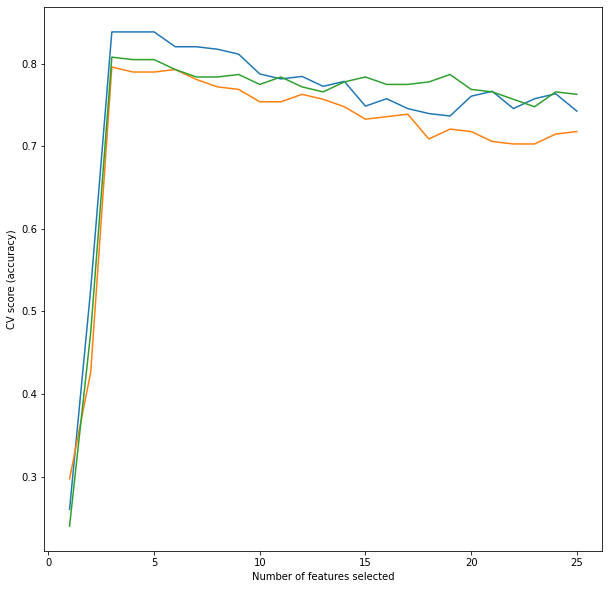

In [44]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
import numpy as np


X, y = make_classification(
    n_samples=1000,
    n_features=25,
    n_informative=3,
    n_redundant=2,
    n_repeated=0,
    n_classes=8,
    n_clusters_per_class=1,
    random_state=0,
)
cv_number = 3

# 建立 RFECV
estimator = SVC(kernel="linear")
rfecv = RFECV(
    estimator=estimator ,
    step=1,
    cv=StratifiedKFold(cv_number),
    scoring="accuracy",
    min_features_to_select=1,
).fit(X, y)

print('Support: \n%s' % rfecv.support_)
print('Rank: \n%s' % rfecv.ranking_)
print("Optimal number of features : %d" % rfecv.n_features_)

scores = np.transpose([rfecv.cv_results_['split%s_test_score'%i] for i in range(cv_number)])

# Plot
plt.figure(figsize=(10,10))
plt.xlabel("Number of features selected")
plt.ylabel("CV score (accuracy)")
plt.plot(range(1, len(scores) + 1), scores)
plt.show()


In [48]:
# 得到他
rfecv.transform(X)

array([[ 0.15007977,  2.66158504,  1.01699057],
       [ 0.67112041,  2.65680383, -0.54236691],
       [-0.21675353, -1.94083679,  1.05601842],
       ...,
       [ 0.87299711,  1.23563709,  0.8920512 ],
       [ 0.00740367,  0.36885175,  1.19109903],
       [ 0.50742874,  0.4125871 , -1.04081764]])

# SelectFromModel

下面要提的 SelectFromModel 使用的方法是 meta-transformer，
使用的方法跟上面說的很像，要先準備一個模型，
這個模型要有 ``feature_importances_`` or ``coef_`` 屬性，
模型是要訓練過的，然後要設定 ``prefit=True``。



下面就來看一個簡單的使用例子。



In [58]:
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel

X, y = make_classification(
    n_samples=1000,
    n_features=25,
    n_informative=3,
    n_redundant=2,
    n_repeated=0,
    n_classes=8,
    n_clusters_per_class=1,
    random_state=87,
)

# 要放訓練過的模型
estimator = SVC(kernel='linear', C=1).fit(X, y)
X_new = SelectFromModel(estimator, prefit=True).transform(X)

print('Data shape: ', X.shape)
print('New Data Shape: ', X_new.shape)



Data shape:  (1000, 25)
New Data Shape:  (1000, 5)


還有其他的特徵選擇器，目前就介紹到這邊，更多內容可以參考 [feature_selection](https://scikit-learn.org/stable/modules/feature_selection.html)。